In [1]:
import os
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

from algos import *
from infect import *
from sbm import *

In [ ]:
# Testing infect

N = 256
M = 16
q0 = 0.5
q1 = 0.3
G = SBM(N, M, q0, q1)
# visualize_graph(G)

p0 = 0.001  # Initial infection probability
p1 = 0.3  # Probability of infection spread to neighbors
time_steps = 2  # Number of days to simulate the infection spread

infected_individuals = infect(G, p0, p1, time_steps)

# plot_infection_progression(infected_individuals)

def print_subarrays(infected_individuals, N, M):
    N = len(infected_individuals)
    group_size = N // M

    for i in range(M):
        start_index = i * group_size
        end_index = start_index + group_size
        subarray = infected_individuals[start_index:end_index]
        print(f"Community {i + 1}: {subarray}", "Num infected:", sum(subarray))

print("Number of infected individuals after 2 days are", sum(infected_individuals))
print_subarrays(infected_individuals, N, M)

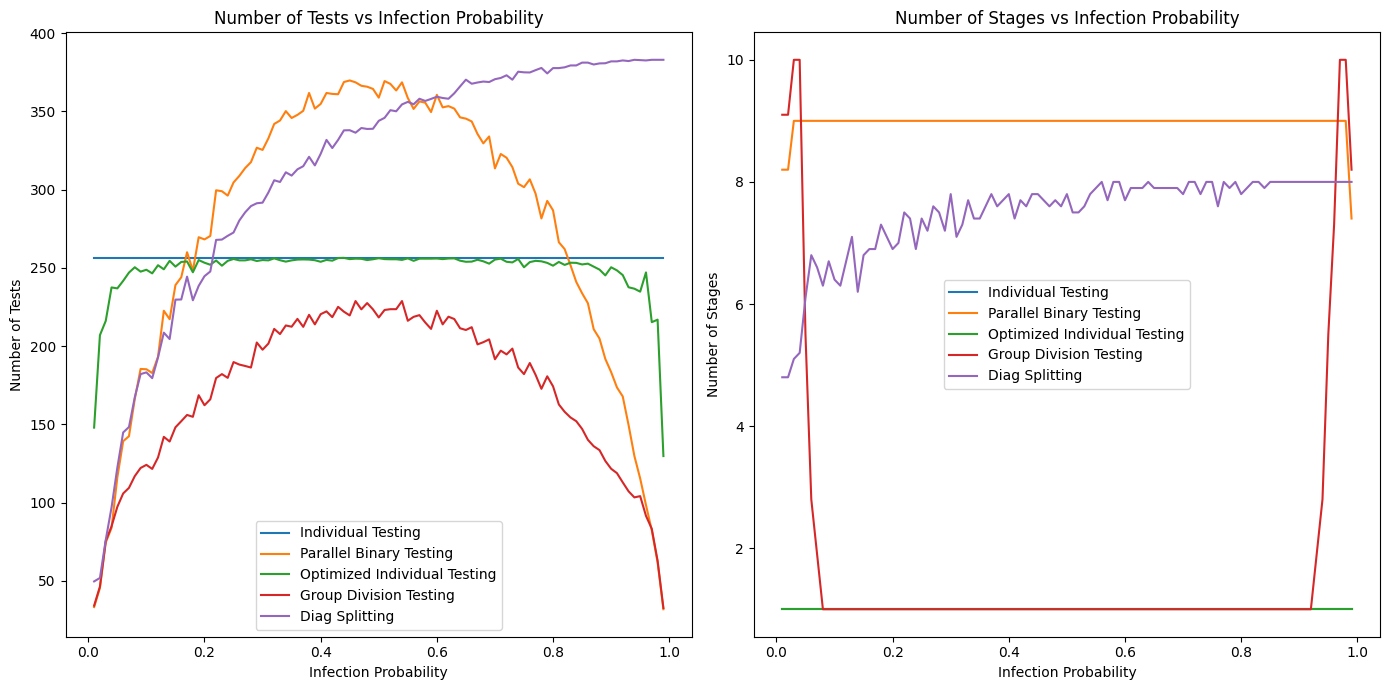

In [481]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of simulations to average over
num_simulations = 10

# Initialize lists to store results
infection_probs = np.arange(0.01, 1, 0.01)
individual_tests_list = []
parallel_binary_tests_list = []
optimized_individual_tests_list = []
group_division_tests_list = []
diag_splitting_tests_list = []

individual_stages_list = []
parallel_binary_stages_list = []
optimized_individual_stages_list = []
group_division_stages_list = []
diag_splitting_stages_list = []

# Iterate over infection probabilities
for p in infection_probs:
    individual_tests_avg = 0
    parallel_binary_tests_avg = 0
    optimized_individual_tests_avg = 0
    group_division_tests_avg = 0
    diag_splitting_tests_avg = 0
    
    individual_stages_avg = 0
    parallel_binary_stages_avg = 0
    optimized_individual_stages_avg = 0
    group_division_stages_avg = 0
    diag_splitting_stages_avg = 0
    
    for _ in range(num_simulations):  # Average over num_simulations tests
        array = np.random.choice([0, 1], size=256, p=[1 - p, p])

        individual_tests, individual_stages = individual_testing(array)
        parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
        optimized_individual_tests, optimized_individual_stages = optimized_individual_testing(array)
        group_division_tests, group_division_stages = group_division_testing(array)
        diag_splitting_tests, diag_splitting_stages = diag_splitting(array)

        individual_tests_avg += individual_tests
        parallel_binary_tests_avg += parallel_binary_tests
        optimized_individual_tests_avg += optimized_individual_tests
        group_division_tests_avg += group_division_tests
        diag_splitting_tests_avg += diag_splitting_tests

        individual_stages_avg += individual_stages
        parallel_binary_stages_avg += parallel_binary_stages
        optimized_individual_stages_avg += optimized_individual_stages
        group_division_stages_avg += group_division_stages
        diag_splitting_stages_avg += diag_splitting_stages

    individual_tests_list.append(individual_tests_avg / num_simulations)
    parallel_binary_tests_list.append(parallel_binary_tests_avg / num_simulations)
    optimized_individual_tests_list.append(optimized_individual_tests_avg / num_simulations)
    group_division_tests_list.append(group_division_tests_avg / num_simulations)
    diag_splitting_tests_list.append(diag_splitting_tests_avg / num_simulations)

    individual_stages_list.append(individual_stages_avg / num_simulations)
    parallel_binary_stages_list.append(parallel_binary_stages_avg / num_simulations)
    optimized_individual_stages_list.append(optimized_individual_stages_avg / num_simulations)
    group_division_stages_list.append(group_division_stages_avg / num_simulations)
    diag_splitting_stages_list.append(diag_splitting_stages_avg / num_simulations)

# Plotting the number of tests
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(infection_probs, individual_tests_list, label='Individual Testing')
plt.plot(infection_probs, parallel_binary_tests_list, label='Parallel Binary Testing')
plt.plot(infection_probs, optimized_individual_tests_list, label='Optimized Individual Testing')
plt.plot(infection_probs, group_division_tests_list, label='Group Division Testing')
plt.plot(infection_probs, diag_splitting_tests_list, label='Diag Splitting')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Tests')
plt.title('Number of Tests vs Infection Probability')
plt.legend()

# Plotting the number of stages
plt.subplot(1, 2, 2)
plt.plot(infection_probs, individual_stages_list, label='Individual Testing')
plt.plot(infection_probs, parallel_binary_stages_list, label='Parallel Binary Testing')
plt.plot(infection_probs, optimized_individual_stages_list, label='Optimized Individual Testing')
plt.plot(infection_probs, group_division_stages_list, label='Group Division Testing')
plt.plot(infection_probs, diag_splitting_stages_list, label='Diag Splitting')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Stages')
plt.title('Number of Stages vs Infection Probability')
plt.legend()

plt.tight_layout()
plt.show()



In [585]:
def individual_testing(s):
    num = len(s)
    stages = 1
    return num, stages


def optimized_individual_testing(s):
    """
    Aim: This is an optimization over individual testing by leveraging T1 test information
    Features: Search Pruning, 0-1 Symmetry
    Performance: Approx 30% improvement over individual testing when infection rate is extremely 
                low or high (<0.1 or 0.9>)
    """
    num = 0
    stages = 1
    total_infected = sum(s)
    num+=1
    proportion_of_positive_tests = total_infected/len(s)

    # To avoid hassle of individual testing
    if proportion_of_positive_tests==0 or proportion_of_positive_tests==1: 
        return num, stages

    stages += 1
    positive_tests = 0
    negative_tests = 0

    # Based on proportion, we either look for ones or zeros
    if(proportion_of_positive_tests <= 0.5):
      for i in range(len(s)):
          if s[i] == 1:
            positive_tests += 1
          num+=1
          if positive_tests==sum(s): break

    else:
      for i in range(len(s)):
          if s[i] == 0:
            negative_tests += 1
          num+=1
          if negative_tests==(len(s)-sum(s)): break

    return num, stages



# binary spliting
def binary_splitting_round(s):
    # s: np.array the infectious status & test status
    # Number of tests performed
    num = 0
    # num infected > 1?
    flag = sum(s[:,0])>0
    assert flag
    # num stages till now
    stages = 0
    # if there's one person, set their test status to infection status
    if len(s[:,0])==1:
        s[0,1] = s[0,0]
        return num,s,stages

    # Split array in half
    B1, B2 = np.array_split(s.copy(), 2,axis=0)
    flag = sum(B1[:,0])>0
    num+=1
    stages += 1

    if flag:
        n,stmp,stage = binary_splitting_round(B1)
        s[:len(B1),1] = stmp[:,1]
    else:
        s[:len(B1),1] = 0
        n,stmp,stage = binary_splitting_round(B2)
        s[len(B1):,1] = stmp[:,1]
    num += n
    stages += stage
    return num,s,stages

def binary_splitting(s):
    # modified bs
    # s: 1-d array the infectious status
    st = np.zeros((len(s),2))
    st[:,0] = s
    st[:,1] = np.nan
    nums = 0
    count = sum(np.isnan(st[:,1]))
    stages = 0
    # the undetermined people
    while count!=0:
        mask = np.isnan(st[:,1])
        flag = sum(st[mask,0]>0)>0
        nums += 1
        stages+=1
        if not flag:
            st[mask,1] = 0
        else:
            n,stmp,stage = binary_splitting_round(st[mask,:])
            st[mask,1] = stmp[:,1]
            nums += n
            stages += stage
        count = sum(np.isnan(st[:,1]))

    assert sum(st[:,0]!=st[:,1])==0
    return nums,stages, st[:,1]



def parallel_binary_splitting(s):

    """
    Aim: Reduce repetitive overhead of binary splitting and leverage T1 test information
    Features: Parallel Searching, Search Pruning, 0-1 Symmetry
    Performance: Way beter than binary splitting, on average worse than diagonal splitting
    [CONSIDER ADDING THRESHOLDING BASE CASE - idea discarded after poor results]
    """

    num, stages = 0,1
    if len(s)==0: return num, stages

    num+=1
    num_infected = sum(s)
    # Base Case: Prune len(s)
    if num_infected == 0 or num_infected==len(s): return num, stages
    # if num_infected > 0.8: return optimized_individual_testing(s)

    mid = len(s)//2
    left_half = s[:mid].copy()
    right_half = s[mid:].copy()
    
    num_left, stages_left = parallel_binary_splitting(left_half)
    num_right, stages_right = parallel_binary_splitting(right_half)
    
    num += num_left + num_right
    stages += max(stages_left,stages_right)

    return num, stages



# diag
def diagalg_iter(s):
    # s(np.array): binary string of infection status
    # Ex: [1,0,0,1,0,0,1,0]
    # k = 3 (iteration number)
    k = int(np.log2(len(s)))
    # l = 4
    l = int(2**(k-1))
    lp = 0
    # p = [0,0,0,0] (num_of_groups)
    p = np.zeros(k+1)
    group = dict()
    # num = [1,1,1,1]
    num = np.ones(k+1,dtype=np.int32)
    for i in range(k):
        p[i] = sum(s[lp:lp+l])>0
        group[i] = s[lp:lp+l]
        num[i] = l
        lp+=l
        l = l//2

    p[-1] = s[-1]
    group[k] = np.array([s[-1]])
    # p(array): pattern
    # group(dict): indicate the group information
    # num(array): the group size
    return p.astype(np.int32), group,num


def diag_splitting(s):
    # s(np.array): binary string of infection status
    num_tests = 0
    stages = 0
    pattern, group, nums = diagalg_iter(s)
    stages +=1
    num_tests += len(pattern)
    indices = np.where(pattern == 1)[0]
    flag = 0
    for i in indices:
        if nums[i]>1:
            num_test,stage = diag_splitting(group[i])
            num_tests += num_test
            if not flag:
                stages+=stage
                flag = 1
    return num_tests,stages


def group_division_testing(s, threshold = 0.15):
    """
    Aim: Divide the population into groups of size s before testing. 
    Features: Group size determined by infection rate, 
            Switch to parallel_binary_splitting if infection rate is too low
            Switch to individual testing (optimized) if infection rate is too high
    Performance: Significantly better than diagonal testing for all initial probabilities!
    """

    num, stages = 0, 0
    if len(s) == 0: 
        return num, stages

    num_infected = sum(s)
    num+=1
    stages += 1

    if num_infected == 0 or num_infected==len(s): return num, stages

    if num_infected/len(s) < 0.05 or num_infected/len(s) > 0.95:
        bin_num, bin_stages = parallel_binary_splitting(s)
        num += bin_num
        stages += bin_stages
        return num, stages
    
    # Lesser the proportion of infected, larger the group size?
    if num_infected/len(s) < threshold or num_infected/len(s) > (1-threshold):
        group_size = max(1, len(s) // 32)
    else:
        group_size = max(1, len(s) // 64)
    groups = [s[i:i + group_size] for i in range(0, len(s), group_size)]
    
    # Apply conditional parallel binary splitting on each group
    for group in groups:
        if len(group) > 1:
            num_sub, stages_sub = Qtesting1_bin(group)
            num += num_sub
            stages = max(stages, stages_sub)
    
    return num, stages

def perform_T2_test(s):
    num_infected = sum(s)
    # Key:
    # 0 --> [0,0]
    # 1 --> [1,2)
    # 3 --> [2,4)
    # 6 --> [4,8)
    # _ --> [8, len(s))
    if num_infected == 0: return 0
    elif num_infected < 2: return 1
    elif num_infected < 4: return 3
    elif num_infected < 8: return 6
    else: return (8+len(s))/2


def parallel_binary_splitting_T2(s):
    """
    Aim: Adapt parallel binary splitting to use only T2 tests
    """

    num, stages = 0,1
    if len(s)==0: return num, stages

    num+=1
    num_infected = perform_T2_test(s)
    if num_infected == 0 or len(s)==1: return num, stages

    mid = len(s)//2
    left_half = s[:mid].copy()
    right_half = s[mid:].copy()
    
    num_left, stages_left = parallel_binary_splitting_T2(left_half)
    num_right, stages_right = parallel_binary_splitting_T2(right_half)
    
    num += num_left + num_right
    stages += max(stages_left,stages_right)

    return num, stages


def group_division_testing_T2(s, threshold = 0.20):
    """
    Adapt Group Division Testing to work for T2 tests
    """

    num, stages = 0, 0
    if len(s) == 0: 
        return num, stages

    approx_num_infected = perform_T2_test(s)
    num+=1
    stages += 1

    if approx_num_infected == 0: return num, stages

    # Lesser the proportion of infected, larger the group size?
    if approx_num_infected/len(s) < threshold:
        group_size = max(1, len(s) // 32)
    else:
        group_size = max(1, len(s) // 64)
    groups = [s[i:i + group_size] for i in range(0, len(s), group_size)]
    
    # Apply conditional parallel binary splitting on each group
    for group in groups:
        if len(group) > 1:
            num_sub, stages_sub = Qtesting2_bin(group)
            num += num_sub
            stages = max(stages, stages_sub)
    
    return num, stages



def Qtesting1_bin(s, threshold = 0.2):
    """
    Aim: When infection rate is high, individual testing performs better than binary 
        and diagonal splitting. We leverage T1 tests to set a threshold which decides 
        when to switch to individual testing (optimized version).
    """
    num,stages = 0,0
    num_infected = sum(s)
    # I'm not incrementing tests/stages here bcs I redo this test at the start of both the functions I call
    # It is a matter of convenience that I choose not to pass this test's result as an argument
    
    if num_infected/len(s) > threshold and num_infected/len(s) < (1-threshold):
        temp_num, temp_stages = optimized_individual_testing(s)
        num += temp_num
        stages += temp_stages
        return num, stages

    temp_num, temp_stages = parallel_binary_splitting(s)
    num += temp_num
    stages += temp_stages

    return num,stages


def Qtesting2_bin(s, threshold = 0.2):
    """
    Aim: When infection rate is high, individual testing performs better than binary 
        and diagonal splitting. We leverage T1 tests to set a threshold which decides 
        when to switch to individual testing (optimized version).
    """
    num,stages = 0,0
    num_infected = perform_T2_test(s)
    # I'm not incrementing tests/stages here bcs I redo this test at the start of both the functions I call
    # It is a matter of convenience that I choose not to pass this test's result as an argument
    
    if num_infected/len(s) > threshold:
        temp_num, temp_stages = individual_testing(s)
        num += temp_num
        stages += temp_stages
        return num, stages

    temp_num, temp_stages = parallel_binary_splitting_T2(s)
    num += temp_num
    stages += temp_stages

    return num,stages


def Qtesting1(s):
    # Return our best performing model :)
    return group_division_testing(s)


def Qtesting2(s):
    return group_division_testing_T2(s)



# def pool_communities(communities):
#     pooled_communities = []
    
#     # Iterate over the communities in steps of 2
#     for i in range(0, len(communities), 2):
#         # Pool every two consecutive communities
#         pooled_community = communities[i]
#         if i + 1 < len(communities):
#             pooled_community = np.concatenate((communities[i], communities[i + 1]))
#         pooled_communities.append(pooled_community)
    
#     return np.array(pooled_communities)


# def Qtesting1_comm_aware(s, communities):
#     '''
#     s(np.array): binary string of infection status
#     communities(list): the community information
#     '''
#     num_tests = 0
#     stages = 0

#     num_infected = sum(s)
#     num_tests+=1
#     stages+=1
    
#     if num_infected == 0 or num_infected == len(s): return num_tests, stages


#     while(len(communities[0])/len(s) <= 1/32):
#         communities = pool_communities(communities)

#     communities = np.array(communities)
#     s = np.array(s)

#     for community in communities:
#         temp_tests, temp_stages = Qtesting1_bin(s[community])
#         num_tests += temp_tests
#         stages = max(temp_stages,stages)
    
#     stages += 1

#     return num_tests, stages




def Qtesting1_comm_aware(s, communities):
    '''
    s (np.array): binary string of infection status
    communities (list of lists): the community information
    '''
    num_tests = 0
    stages = 0

    # Initial test to determine the presence of any infection
    num_infected = np.sum(s)
    num_tests += 1
    stages += 1
    
    if num_infected == 0 or num_infected == len(s):
        return num_tests, stages
    
    # Pooling communities until a certain size
    while len(communities[0]) / len(s) <= 1/32:
        communities = pool_communities(communities)

    communities = np.array(communities)
    s = np.array(s)

    for community in communities:
        temp_tests, temp_stages = Qtesting1_bin(s[community])
        num_tests += temp_tests
        stages = max(temp_stages, stages)
    
    return num_tests, stages

def pool_communities(communities):
    pooled_communities = []
    temp_community = []

    for community in communities:
        temp_community.extend(community)
        if len(temp_community) >= len(community) * 2:
            pooled_communities.append(temp_community)
            temp_community = []

    if temp_community:
        pooled_communities.append(temp_community)

    return pooled_communities




def Qtesting1_comm_aware_bin(s, communities):
    '''
    s(np.array): binary string of infection status
    communities(list): the community information
    '''
    num_tests = 0
    stages = 0
    communities = np.array(communities)
    s = np.array(s)


    for community in communities:
        num_tests += 1
        if sum(community) == 0: continue
        if sum(community)/len(community) <= 1/128:
            temp_tests, temp_stages = Qtesting1_bin(s[community])
            num_tests += temp_tests
        else:
            temp_tests, temp_stages = Qtesting1(s[community])
            num_tests += temp_tests
        stages = max(temp_stages,stages)

    return num_tests, stages



def Qtesting2_comm_aware(s,communities):
    '''
    s(np.array): binary string of infection status
    communities(list): the community information
    '''
    num_tests = 0
    stages = 0
    ###################################################
    '''your code here'''

    ###################################################



    return num_tests,stages

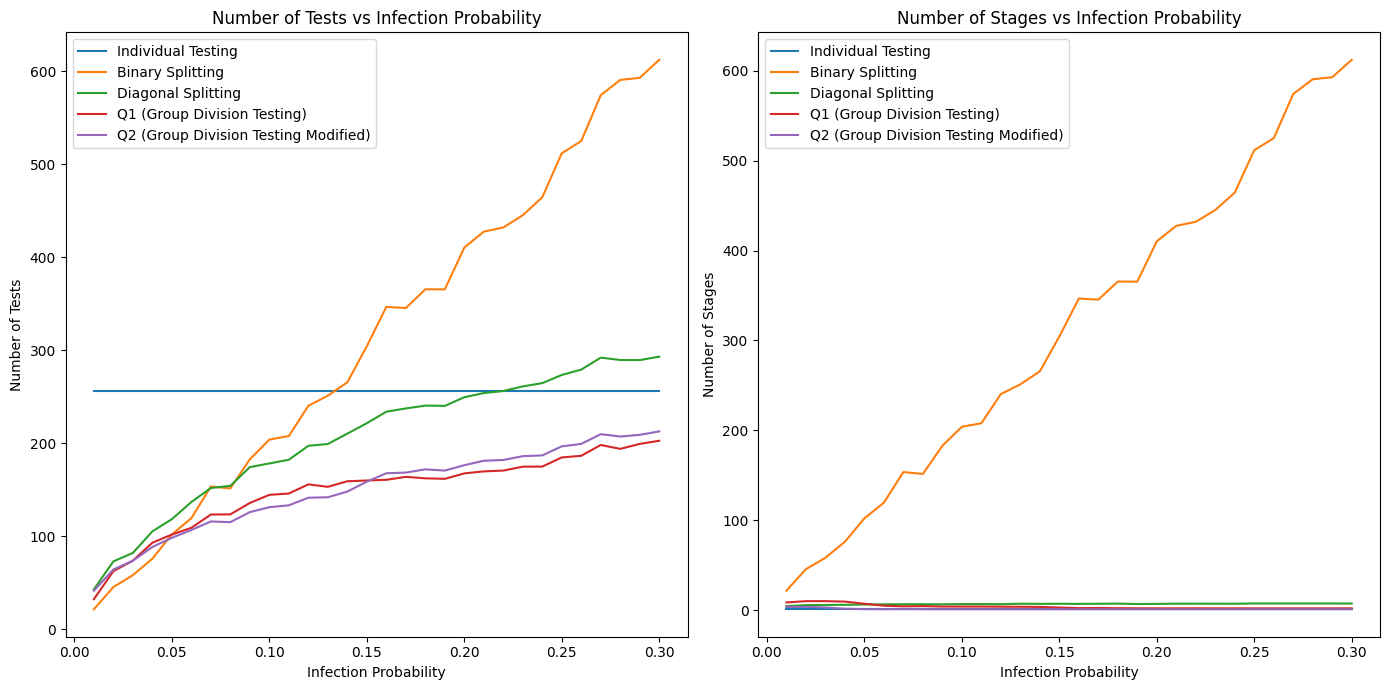

In [562]:
# Number of simulations to average over
num_simulations = 25
np.random.seed(55)

# Initialize lists to store results
infection_probs = np.arange(0.01, 0.31, 0.01)
individual_tests_list = []
binary_tests_list = []
parallel_binary_tests_list = []
diag_tests_list = []
Q1_tests_list = []
group_division_tests_list = []

individual_stages_list = []
binary_stages_list = []
parallel_binary_stages_list = []
diag_stages_list = []
Q1_stages_list = []
group_division_stages_list = []

# Iterate over infection probabilities
for p in infection_probs:
    individual_tests_avg, binary_tests_avg, parallel_binary_tests_avg = 0, 0, 0
    diag_tests_avg, Q1_tests_avg, group_division_tests_avg = 0, 0, 0
    individual_stages_avg, binary_stages_avg, parallel_binary_stages_avg = 0, 0, 0
    diag_stages_avg, Q1_stages_avg, group_division_stages_avg = 0, 0, 0
    
    for _ in range(num_simulations):  # Average over num_simulations tests
        array = np.random.choice([0, 1], size=256, p=[1 - p, p])

        individual_tests, individual_stages = individual_testing(array)
        binary_tests, binary_stages = binary_splitting(array)[0:2]
        parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
        diag_tests, diag_stages = diag_splitting(array)
        Q1_tests, Q1_stages = Qtesting1(array)
        group_division_tests, group_division_stages = Qtesting2(array)

        individual_tests_avg += individual_tests
        binary_tests_avg += binary_tests
        parallel_binary_tests_avg += parallel_binary_tests
        diag_tests_avg += diag_tests
        Q1_tests_avg += Q1_tests
        group_division_tests_avg += group_division_tests

        individual_stages_avg += individual_stages
        binary_stages_avg += binary_stages
        parallel_binary_stages_avg += parallel_binary_stages
        diag_stages_avg += diag_stages
        Q1_stages_avg += Q1_stages
        group_division_stages_avg += group_division_stages

    individual_tests_list.append(individual_tests_avg / num_simulations)
    binary_tests_list.append(binary_tests_avg / num_simulations)
    parallel_binary_tests_list.append(parallel_binary_tests_avg / num_simulations)
    diag_tests_list.append(diag_tests_avg / num_simulations)
    Q1_tests_list.append(Q1_tests_avg / num_simulations)
    group_division_tests_list.append(group_division_tests_avg / num_simulations)

    individual_stages_list.append(individual_stages_avg / num_simulations)
    binary_stages_list.append(binary_stages_avg / num_simulations)
    parallel_binary_stages_list.append(parallel_binary_stages_avg / num_simulations)
    diag_stages_list.append(diag_stages_avg / num_simulations)
    Q1_stages_list.append(Q1_stages_avg / num_simulations)
    group_division_stages_list.append(group_division_stages_avg / num_simulations)

# Plotting the number of tests
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(infection_probs, individual_tests_list, label='Individual Testing')
plt.plot(infection_probs, binary_tests_list, label='Binary Splitting')
# plt.plot(infection_probs, parallel_binary_tests_list, label='Parallel Binary Splitting')
plt.plot(infection_probs, diag_tests_list, label='Diagonal Splitting')
plt.plot(infection_probs, Q1_tests_list, label='Q1 (Group Division Testing)')
plt.plot(infection_probs, group_division_tests_list, label='Q2 (Group Division Testing Modified)')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Tests')
plt.title('Number of Tests vs Infection Probability')
plt.legend()

# Plotting the number of stages
plt.subplot(1, 2, 2)
plt.plot(infection_probs, individual_stages_list, label='Individual Testing')
plt.plot(infection_probs, binary_stages_list, label='Binary Splitting')
# plt.plot(infection_probs, parallel_binary_stages_list, label='Parallel Binary Splitting')
plt.plot(infection_probs, diag_stages_list, label='Diagonal Splitting')
plt.plot(infection_probs, Q1_stages_list, label='Q1 (Group Division Testing)')
plt.plot(infection_probs, group_division_stages_list, label='Q2 (Group Division Testing Modified)')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Stages')
plt.title('Number of Stages vs Infection Probability')
plt.legend()

plt.tight_layout()
plt.show()


In [494]:
# Function Tests

infection_probability = 0.01
iterations = 100

# Initialize arrays to store results
individual_tests_results = []
individual_stages_results = []
opt_individual_tests_results = []
opt_individual_stages_results = []
parallel_binary_tests_results = []
parallel_binary_stages_results = []
diag_tests_results = []
diag_stages_results = []
Q1_tests_results = []
Q1_stages_results = []
Q1_bin_tests_results = []
Q1_bin_stages_results = []

for _ in range(iterations):
    array = np.random.choice([0, 1], size=256, p=[1 - infection_probability, infection_probability])
    
    individual_tests, individual_stages = individual_testing(array)
    individual_tests_results.append(individual_tests)
    individual_stages_results.append(individual_stages)
    
    opt_individual_tests, opt_individual_stages = optimized_individual_testing(array)
    opt_individual_tests_results.append(opt_individual_tests)
    opt_individual_stages_results.append(opt_individual_stages)
    
    parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
    parallel_binary_tests_results.append(parallel_binary_tests)
    parallel_binary_stages_results.append(parallel_binary_stages)
    
    diag_tests, diag_stages = diag_splitting(array)
    diag_tests_results.append(diag_tests)
    diag_stages_results.append(diag_stages)
    
    Q1_tests, Q1_stages = Qtesting1(array)
    Q1_tests_results.append(Q1_tests)
    Q1_stages_results.append(Q1_stages)
    
    Q1_bin_tests, Q1_bin_stages = Qtesting1_bin(array)
    Q1_bin_tests_results.append(Q1_bin_tests)
    Q1_bin_stages_results.append(Q1_bin_stages)

# Calculate averages
avg_individual_tests = np.mean(individual_tests_results)
avg_individual_stages = np.mean(individual_stages_results)
avg_opt_individual_tests = np.mean(opt_individual_tests_results)
avg_opt_individual_stages = np.mean(opt_individual_stages_results)
avg_parallel_binary_tests = np.mean(parallel_binary_tests_results)
avg_parallel_binary_stages = np.mean(parallel_binary_stages_results)
avg_diag_tests = np.mean(diag_tests_results)
avg_diag_stages = np.mean(diag_stages_results)
avg_Q1_tests = np.mean(Q1_tests_results)
avg_Q1_stages = np.mean(Q1_stages_results)
avg_Q1_bin_tests = np.mean(Q1_bin_tests_results)
avg_Q1_bin_stages = np.mean(Q1_bin_stages_results)

# Print results
print(f"Average results for infection probability = {infection_probability} over {iterations} iterations:")
print(f"Naive: {avg_individual_tests:.2f} tests, {avg_individual_stages:.2f} stages")
print(f"Optimized Naive: {avg_opt_individual_tests:.2f} tests, {avg_opt_individual_stages:.2f} stages")
print(f"Parallel Binary: {avg_parallel_binary_tests:.2f} tests, {avg_parallel_binary_stages:.2f} stages")
print(f"Diag: {avg_diag_tests:.2f} tests, {avg_diag_stages:.2f} stages")
print(f"Q1: {avg_Q1_tests:.2f} tests, {avg_Q1_stages:.2f} stages")
print(f"Q1 Bin: {avg_Q1_bin_tests:.2f} tests, {avg_Q1_bin_stages:.2f} stages")

Average results for infection probability = 0.01 over 100 iterations:
Naive: 256.00 tests, 1.00 stages
Optimized Naive: 163.35 tests, 1.90 stages
Parallel Binary: 31.86 tests, 8.20 stages
Diag: 44.02 tests, 4.68 stages
Q1: 32.76 tests, 9.10 stages
Q1 Bin: 32.86 tests, 9.20 stages


In [15]:
def create_communities(N, M):
    """
    Function to create communities with approximately equal number of nodes.

    Parameters:
    N (int): Total number of nodes.
    M (int): Number of communities.

    Returns:
    List[List[int]]: 2D array of indices for each community.
    """
    communities = []
    nodes_per_community = N // M
    extra_nodes = N % M

    start = 0
    for i in range(M):
        end = start + nodes_per_community + (1 if i < extra_nodes else 0)
        communities.append(list(range(start, end)))
        start = end

    return communities

In [573]:
N = 1024
M = 128
q0 = 0.9
q1 = 0.1
p0 = 0.001
p1 = 0.5
time_steps = 2

num_simulations = 100
total_comm_aware_tests = 0
total_comm_aware_stages = 0
total_group_div_tests = 0
total_group_div_stages = 0

for i in range(num_simulations):
  G = SBM(N, M, q0, q1)
  final_state = infect(G, p0, p1, time_steps)

  # print("Total infected:", sum(final_state))
  # print("Percent infected:", sum(final_state)/len(final_state))
  # print_subarrays(final_state, N, M)

  communities = create_communities(N,M)

  comm_aware_tests, comm_aware_stages = Qtesting1_comm_aware(final_state, communities)
  total_comm_aware_tests += comm_aware_tests
  total_comm_aware_stages += comm_aware_stages
  # print("Num Tests Comm", comm_aware_tests)
  # print("Num Stages Comm", comm_aware_stages)

  np.random.shuffle(final_state)
  group_div_tests, group_div_stages = group_division_testing(final_state)
  total_group_div_tests += group_div_tests
  total_group_div_stages += group_div_stages
  # print("Num Tests GD", group_div_tests)
  # print("Num Stages GD", group_div_stages)


print("Average Num Tests Comm", total_comm_aware_tests/num_simulations)
print("Average Num Stages Comm", total_comm_aware_stages/num_simulations)
print("Average Num Tests GD", total_group_div_tests/num_simulations)
print("Average Num Stages GD", total_group_div_stages/num_simulations)


Average Num Tests Comm 38.02
Average Num Stages Comm 3.4
Average Num Tests GD 39.48
Average Num Stages GD 4.6


In [ ]:
N = 256
M = 64
q0 = 1
q1 = 0
p0 = 0.001
p1 = 0.5
time_steps = 2


G = SBM(N, M, q0, q1)
final_state = infect(G, p0, p1, time_steps)
# final_state = np.ones(N)
# final_state[0] = 0

print("Total infected:", sum(final_state))
print("Percent infected:", sum(final_state)/len(final_state))
print_subarrays(final_state, N, M)

communities = create_communities(N,M)

comm_aware_tests, comm_aware_stages = Qtesting1_comm_aware(final_state, communities)

print("Num Tests Comm", comm_aware_tests)
print("Num Stages Comm", comm_aware_stages)

np.random.shuffle(final_state)
group_div_tests, group_div_stages = group_division_testing(final_state)
print("Num Tests GD", group_div_tests)
print("Num Stages GD", group_div_stages)

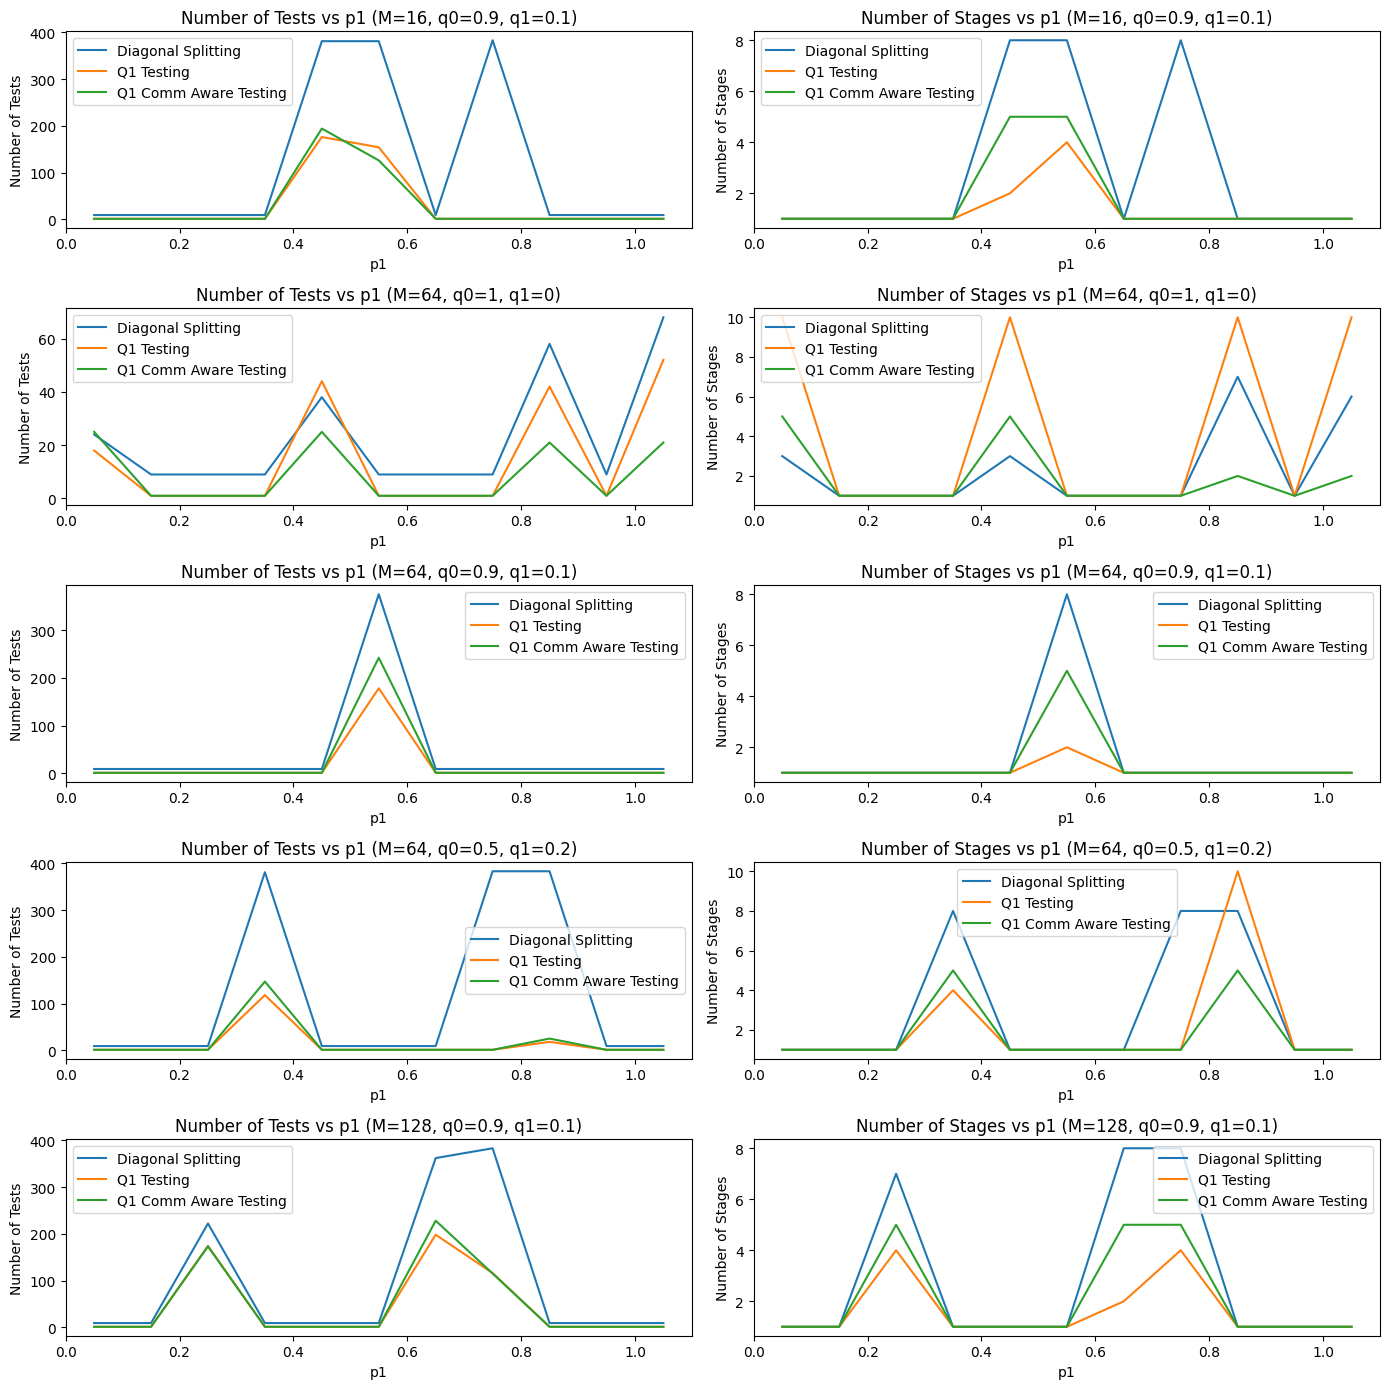

In [589]:
# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"individual": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 10
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        individual_tests_total, individual_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            final_state = infect(G, p0, p1, time_steps)

            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
            np.random.shuffle(final_state)
            individual_tests, individual_stages = individual_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            

            individual_tests_total += individual_tests
            individual_stages_total += individual_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages

        results[(M, q0, q1, p0, time_steps)]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    # plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["individual"]], label='Naive Testing')
    # plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    # plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["individual"]], label='Naive Testing')
    # plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()


In [427]:
def iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm'):

    name = dataset+'N'+str(N)+'_M'+str(M)+'_SIM'+str(num_sims)+'_step'+str(time_steps)+'_q0'+str(q0)+'_q1'+str(q1)+'_p0'+str(p0)+'_p1'+str(p1)+method+'graphs.pkl'
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims,N,N))
        Communities = dict()
        data = dict()
        Individuals = dict()
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i] = SBM(N,M,q0,q1)
                ###################################################
                '''your code here'''
                # communities = []
                communities = create_communities(N,M)
                ###################################################
                Communities[i] = communities
                Individuals[i] = infect(Gs[i],p0,p1,time_steps)
        elif dataset=='iid':
            for i in range(num_sims):
                ###################################################
                '''your code here'''
                # Individuals[i] = 
                # Communities[i] =[[all individuals]]
                Individuals[i] =  np.random.choice([0, 1], size=256, p=[1 - p0, p0])
                Communities[i] =[Individuals[i]]
                ###################################################
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 
    #         print('Dataset done!')


    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    num_tests = 0
    num_stages = 0
    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        # print('Data loaded!')
    for i in range(num_sims):
        if dataset=='sbm':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
            
            #################################################
            fraction_ppl += sum(individuals)/len(individuals)

            num_infected_communities = 0
            infection_concentration = 0
            for community in communities:
                # print(sum(individuals[community]))
                if sum(individuals[community])>0:
                    num_infected_communities += 1
                    infection_concentration += sum(individuals[community])/len(community)

            fraction_family += num_infected_communities/len(communities)
            if num_infected_communities >0:
                fraction_ppl_in_family += infection_concentration/num_infected_communities
            else: fraction_ppl_in_family += 0


        ###################################################
        '''your code to calculate the statistics above^^^''' 

        
        ###################################################

        # interleave the individuals
        # s = individuals.copy()
        # np.random.shuffle(s)
        # # binary
        # numtests_bs, num_stages_bs, _ = binary_splitting(s)
        # # algorithm 1
        # numtests_q1, num_stages_q1 = Qtesting1(s)
        # # algorithm 2
        # numtests_q2, num_stages_q2 = Qtesting2(s)
        # # community-aware
        # numtests_q1_c, num_stages_q1_c = Qtesting1_comm_aware(individuals.copy(),communities)
        # # community-aware
        # numtests_q2_c, num_stages_q2_c = Qtesting2_comm_aware(individuals.copy(),communities)

    ###################################################
    '''your code to calculate the statistics here''' 
    '''Do not forget to take the average'''
    fraction_ppl = fraction_ppl/num_sims
    fraction_family = fraction_family/num_sims
    fraction_ppl_in_family = fraction_ppl_in_family/num_sims

    ###################################################
            

    return fraction_ppl, fraction_family, fraction_ppl_in_family, num_tests, num_stages

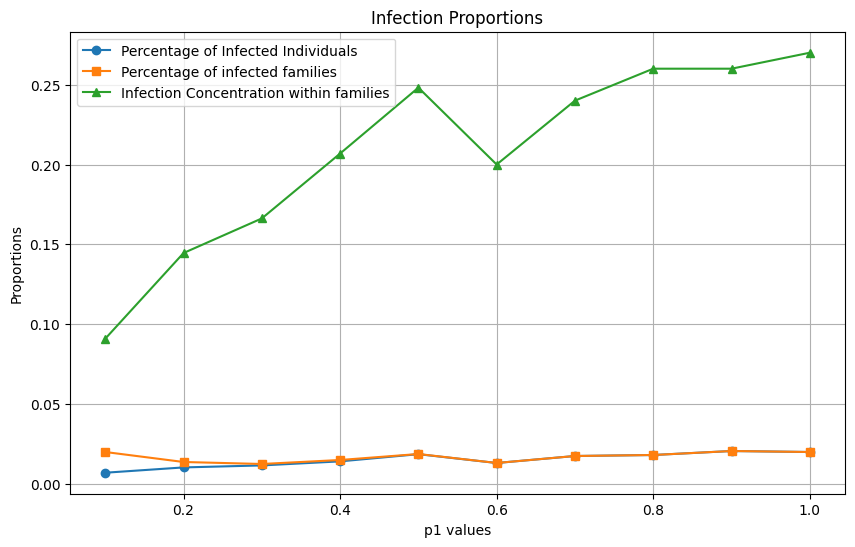

In [429]:
# Simulation and plotting 1
N = 256
M = 16
q0 = 1
q1 = 0
time_steps = 2
p0 = 0.001
num_sims = 100

method = 'infection_rate'

t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
for j in range(1,t+1):
    p1 = j/t
    fraction_infected_ppl[j-1], fraction_infected_clc[j-1], fraction_infected_family[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  


x = np.linspace(0.1, 1, 10)
y1 = fraction_infected_ppl
y2 = fraction_infected_clc
y3 = fraction_infected_family

# Plotting the three arrays
plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Percentage of Infected Individuals', marker='o')
plt.plot(x, y2, label='Percentage of infected families', marker='s')
plt.plot(x, y3, label='Infection Concentration within families', marker='^')

plt.xlabel('p1 values')
plt.ylabel('Proportions')
plt.title('Infection Proportions')
plt.legend()
plt.grid(True)
plt.show()

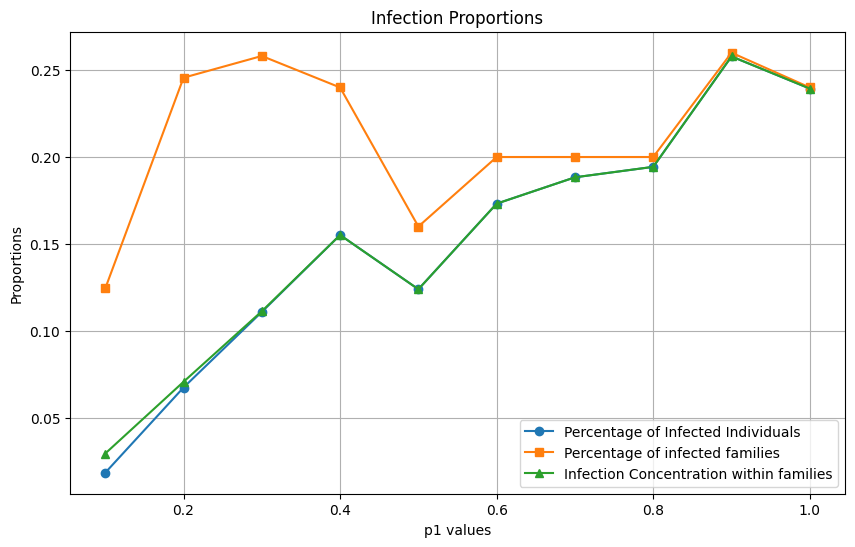

In [431]:
# Simulation and plotting 1
N = 256
M = 16
q0 = 0.9
q1 = 0.1
time_steps = 2
p0 = 0.001
num_sims = 100

method = 'infection_rate'

t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
for j in range(1,t+1):
    p1 = j/t
    fraction_infected_ppl[j-1], fraction_infected_clc[j-1], fraction_infected_family[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  


x = np.linspace(0.1, 1, 10)
y1 = fraction_infected_ppl
y2 = fraction_infected_clc
y3 = fraction_infected_family

# Plotting the three arrays
plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Percentage of Infected Individuals', marker='o')
plt.plot(x, y2, label='Percentage of infected families', marker='s')
plt.plot(x, y3, label='Infection Concentration within families', marker='^')

plt.xlabel('p1 values')
plt.ylabel('Proportions')
plt.title('Infection Proportions')
plt.legend()
plt.grid(True)
plt.show()

Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!


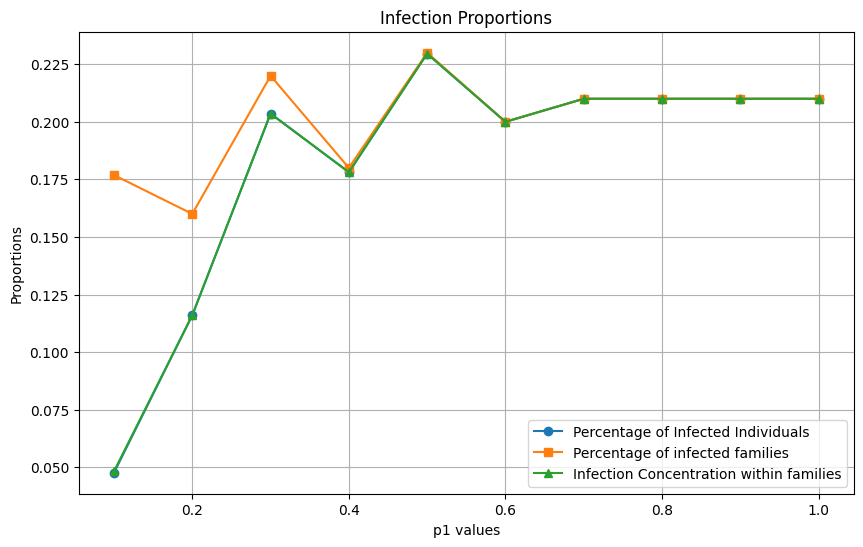

In [434]:
# Simulation and plotting 1
N = 256
M = 16
q0 = 0.5
q1 = 0.3
time_steps = 2
p0 = 0.001
num_sims = 100

method = 'infection_rate'

t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
for j in range(1,t+1):
    p1 = j/t
    fraction_infected_ppl[j-1], fraction_infected_clc[j-1], fraction_infected_family[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  


x = np.linspace(0.1, 1, 10)
y1 = fraction_infected_ppl
y2 = fraction_infected_clc
y3 = fraction_infected_family

# Plotting the three arrays
plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Percentage of Infected Individuals', marker='o')
plt.plot(x, y2, label='Percentage of infected families', marker='s')
plt.plot(x, y3, label='Infection Concentration within families', marker='^')

plt.xlabel('p1 values')
plt.ylabel('Proportions')
plt.title('Infection Proportions')
plt.legend()
plt.grid(True)
plt.show()

